<a href="https://www.kaggle.com/code/mhassaanbutt/breast-cancer-classification-using-eat?scriptVersionId=137595176" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries

In [1]:
import shutil,os, cv2, gc
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import itertools
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

**Data**

The dataset can be downloaded from https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/. 

In [2]:
def create_folds_from_ds(dst_path='/kaggle/working'):
    """Creates a structure of directories containing images
        selected from BreaKHis_v1 dataset. 2,3,4,5
    """
    root_dir = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
    srcfiles = {'DC': '%s/malignant/SOB/ductal_carcinoma/%s/%sX/%s',
                'LC': '%s/malignant/SOB/lobular_carcinoma/%s/%sX/%s',
                'MC': '%s/malignant/SOB/mucinous_carcinoma/%s/%sX/%s',
                'PC': '%s/malignant/SOB/papillary_carcinoma/%s/%sX/%s',
                'A': '%s/benign/SOB/adenosis/%s/%sX/%s',
                'F': '%s/benign/SOB/fibroadenoma/%s/%sX/%s',
                'PT': '%s/benign/SOB/phyllodes_tumor/%s/%sX/%s',
                'TA': '%s/benign/SOB/tubular_adenoma/%s/%sX/%s'}

    
    # directory for nth-fold
    dst_dir = dst_path + '/Breast_Cancer_ Histopathological _Dataset'
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    # image list
    db = open('/kaggle/input/image-files-loader/load_files.txt')
    benign_train = 0
    malignant_train = 0
    
    benign_test = 0
    malignant_test = 0
    
    for row in db.readlines():
        columns = row.split('|')
        imgname = columns[0]
        types = imgname.split('_')[1]
        if types == 'B':
            category = 'benign'
        elif types == 'M':
            category = 'malignant'
        mag = columns[1]  # 40, 100, 200, or 400
        grp = columns[3].strip()  # train or test
        
        dst_subdir = dst_dir + '/' + grp
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
        
        dst_subdir = dst_subdir + '/' + category
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
            
        tumor = imgname.split('-')[0].split('_')[-1]
        srcfile = srcfiles[tumor]
        
        s = imgname.split('-')
        sub = s[0] + '_' + s[1] + '-' + s[2]
        
        srcfile = srcfile % (root_dir, sub, mag, imgname)
        
        dstfile = dst_subdir + '/' + imgname
        
        if grp == 'train' and category == 'benign':
            if benign_train >= 250:
                continue
            else:
                benign_train +=1 
        
        if grp == 'train' and category == 'malignant':
            if malignant_train >= 250:
                continue
            else:
                malignant_train +=1
        
        if grp == 'test' and category == 'benign':
            if benign_test >= 250:
                continue
            else:
                benign_test +=1
        
        if grp == 'test' and category == 'malignant':
            if malignant_test >= 250:
                continue
            else:
                malignant_test +=1
            
        print ("Copying from [%s] to [%s]" % (srcfile, dstfile))
        shutil.copy(srcfile, dstfile)
    print('\n\n\t\t Train/Test Data Creation finished.\n')
    db.close()
    print ("\nProcess completed.")

In [3]:
create_folds_from_ds()

Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-001.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-002.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png] to [/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/SOB_B_A-14-22549AB-100-003.png]
Copying from [/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png] to [/kaggle/working/Breast_Cancer_ 

## Loading the Image from respective folders

In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/benign/',224))
malign_train = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/train/malignant/',224))
benign_test = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/test/benign/',224))
malign_test = np.array(Dataset_loader('/kaggle/working/Breast_Cancer_ Histopathological _Dataset/test/malignant/',224))

100%|██████████| 250/250 [00:03<00:00, 74.92it/s]


After loading the images, create a numpy array of zeroes for labeling benign images and similarly a numpy array of ones for labeling malignant images. 

Also shuffled the dataset and converted the labels into categorical format.

In [5]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
print('Number of training images', X_train.shape[0])

np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
print('Number of testing images', X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

Number of training images 500
Number of testing images 500


**Train-Test Split**

Split the data-set into two sets — train and test sets with 20% and 80% images respectively

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=0
)

## Dataset Sample Vizulaization

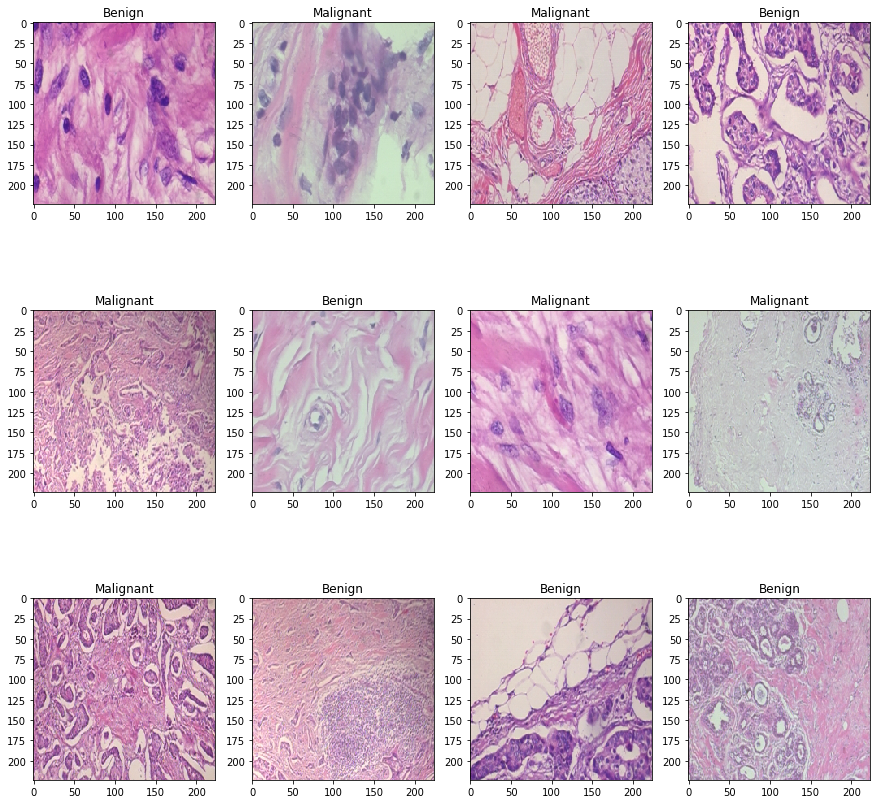

In [7]:
w=20
h=20
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

## Data Augmentation

The practice of data augmentation is an effective way to increase the size of the training set. Augmenting the training examples allow the network to see more diversified, but still representative data points during training.

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## External Attention Transformer Model

### Configure the hyperparameters

In [14]:
input_shape=(224, 224, 3)
num_classes=2
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 4
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 12544


### Implement the patch extraction and encoding layer

In [9]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

### Implement the external attention block

In [10]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

### Implement the MLP block

In [11]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

### Implement the Transformer block

In [12]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

### Implement the EANet model

In [23]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Model Fitting

In [28]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy")
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/50
20/20 [==============================] - 16s 401ms/step - loss: 0.9496 - accuracy: 0.7125 - val_loss: 0.5187 - val_accuracy: 0.9000
Epoch 2/50
20/20 [==============================] - 7s 348ms/step - loss: 0.5422 - accuracy: 0.8750 - val_loss: 0.2806 - val_accuracy: 1.0000
Epoch 3/50
20/20 [==============================] - 7s 343ms/step - loss: 0.3603 - accuracy: 0.9375 - val_loss: 0.2528 - val_accuracy: 0.9500
Epoch 4/50
20/20 [==============================] - 7s 348ms/step - loss: 0.3163 - accuracy: 0.9625 - val_loss: 0.2278 - val_accuracy: 1.0000
Epoch 5/50
20/20 [==============================] - 7s 349ms/step - loss: 0.3014 - accuracy: 0.9750 - val_loss: 0.2256 - val_accuracy: 1.0000
Epoch 6/50
20/20 [==============================] - 7s 349ms/step - loss: 0.2977 - accuracy: 0.9625 - val_loss: 0.2443 - val_accuracy: 1.0000
Epoch 7/50
20/20 [==============================] - 7s 351ms/step - loss: 0.2547 - accuracy: 0.9875 - val_loss: 0.2244 - val_accuracy: 1.0000
Epoch

## Let's visualize the training progress of the model.

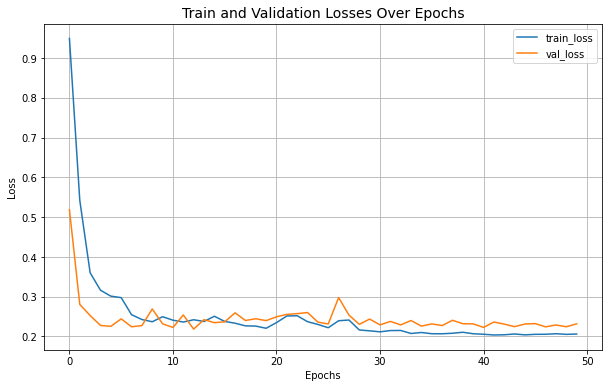

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig('ETA_val_loss_acc_graph.png', dpi=500)
plt.show()

## Let's display the final results of the test

In [36]:
loss, accuracy= model.evaluate(x_val, y_val)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 11s 839ms/step - loss: 0.2379 - accuracy: 0.9950
Test loss: 0.24
Test accuracy: 99.5%


EANet just replaces self attention in Vit with external attention.

## Prediction

In [37]:
Y_pred = model.predict(x_val)

In [40]:
print('Model Accuracy score', accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1)))

Model Accuracy score 0.995


## Performance Metrics

The most common metric for evaluating model performance is the accurcacy. However, when only 2% of your dataset is of one class (malignant) and 98% some other class (benign), misclassification scores don’t really make sense. You can be 99% accurate and still catch none of the malignant cases which could make a terrible classifier.

**Precision, Recall and F1-Score**

For a better look at misclassification, we often use the following metric to get a better idea of true positives (TP), true negatives (TN), false positive (FP) and false negative (FN).

**Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations.

**Recall** is the ratio of correctly predicted positive observations to all the observations in actual class.

**F1-Score** is the harmonic mean of Precision and Recall.

**Confusion Matrix**

Confusion Matrix is a very important metric when analyzing misclassification. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class. The diagonals represent the classes that have been correctly classified. This helps as we not only know which classes are being misclassified but also what they are being misclassified as.

In [45]:
tta_steps = 10
predictions = []
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=batch_size, shuffle=False),
                                    steps = len(X_test)/batch_size)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [02:59<00:00, 17.96s/it]


Confusion matrix, without normalization
[[212  38]
 [  3 247]]


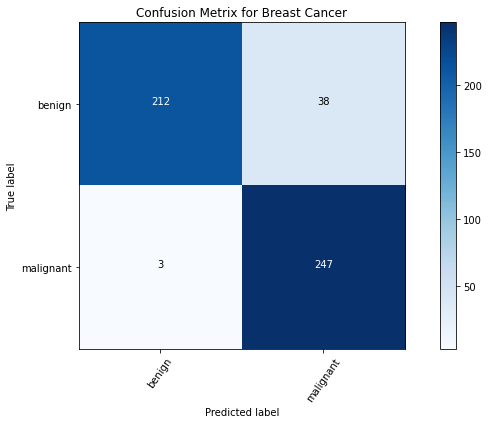

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('ETA_Confusion_Matrix.png', dpi=500)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

In [52]:
# Calculate the classification report
report = classification_report(
    np.argmax(Y_test, axis=1),
    np.argmax(Y_pred_tta, axis=1)
)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       250
           1       0.87      0.99      0.92       250

    accuracy                           0.92       500
   macro avg       0.93      0.92      0.92       500
weighted avg       0.93      0.92      0.92       500



**ROC Curves**

The 45 degree line is the random line, where the Area Under the Curve or AUC is 0.5 . The further the curve from this line, the higher the AUC and better the model. The highest a model can get is an AUC of 1, where the curve forms a right angled triangle. The ROC curve can also help debug a model. For example, if the bottom left corner of the curve is closer to the random line, it implies that the model is misclassifying at Y=0. Whereas, if it is random on the top right, it implies the errors are occurring at Y=1.

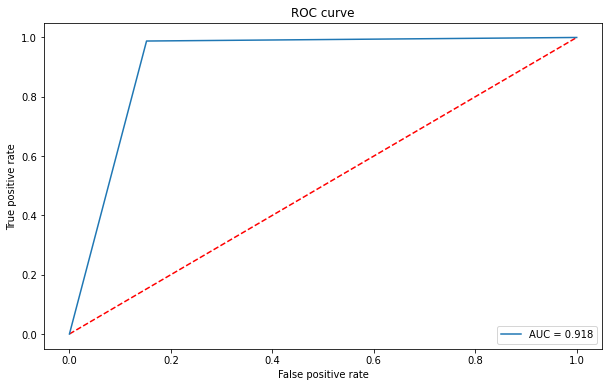

In [54]:
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ETA_ROC_Curve.png', dpi=500)
plt.show()
plt.close()

**Conclusions**

It is remarkable to see the success of deep learning in such varied real world problems. We have demonstrated how to classify benign and malignant breast cancer from a collection of microscopic images using External Attention Transformer.